In [1]:
import xarray as xr

import seaduck as sd
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt

from itertools import accumulate

import os

import sys
sys.path.append('/home/wjiang33/parallel_run/seaduck_post_process/')
from post_process.estimate import *
from post_process.region import *

In [2]:
from matplotlib.dates import date2num, num2date
from matplotlib.collections import LineCollection
from matplotlib import cm
import matplotlib.path as mpath
from tqdm import tqdm

In [3]:
import plot_config
reload(plot_config)

from plot_config import *

In [4]:
ecco_grid = xr.open_zarr('~/ECCO_transport')

In [5]:
# rerun = True

In [6]:
if rerun:
    filedb_lst = []
    for i in range(1,13):
        for j in range(1,4):
            filedb_lst.append(f'/sciserver/filedb{i:02}-0{j}/')
    
    path_mid = 'ocean/wenrui_temp/particle_file/meanM/nc/'
    which_node = list(range(9))
    spread = len(which_node)
    duration = len(os.listdir(filedb_lst[which_node[0]]+path_mid))
    
    dates = [i[-19:] for i in sorted(os.listdir(filedb_lst[which_node[0]]+path_mid),reverse = True)]
    # dates
    
    print(0)
    all_files = []
    for node in which_node:
        path = filedb_lst[node]+path_mid
        all_files.append([path+i for i in sorted(os.listdir(path),reverse = True)])
    all_files = np.array(all_files)
    print(1)
    jt = 0
    date  = dates[jt]
    files = all_files[:,jt]
    datasets = [xr.open_zarr(files[i]) for i in range(len(files))]
    ds0 = datasets[0]
    neo = xr.Dataset()
    neo['shapes'] = xr.concat([ds.shapes for ds in datasets], dim = 'shapes')
    Np = len(neo['shapes'])
    n = 2000
    np.random.seed(0)
    lucky = np.random.randint(0,Np,n)
    print(2)
    
    
    lons = np.zeros((duration, n))
    lats = np.zeros((duration, n))
    
    # t1 = time.time()
    # jt = np.random.randint(1825)
    print(3)
    for jt in range(duration):
        if jt%50==0:
            print(jt)
        date  = dates[jt]
        files = all_files[:,jt]
        assert np.array([(date in name) for name in files]).all()
        # print(time.time()-t1)
        datasets = [xr.open_zarr(files[i]) for i in range(len(files))]
        # print(time.time()-t1)
        ds0 = datasets[0]
        neo = xr.Dataset()
        neo['shapes'] = xr.concat([ds.shapes for ds in datasets], dim = 'shapes')
        nprof = [len(ds.nprof) for ds in datasets]
        prefix = [0]+list(accumulate(nprof))
        neo['wrong_ind'] = xr.concat([datasets[i].wrong_ind+prefix[i] for i in range(len(datasets))], dim = 'wrong_ind')
        for var in ['face','frac','ind1','ind2','ix','iy','iz','tres','tt','vs','xx','yy','zz']:
            neo[var] = xr.concat([ds[var] for ds in datasets], dim = 'nprof')
        # print(time.time()-t1)
        shapes = np.array(neo['shapes'])
        first,last = first_last(shapes)
        lons[jt] = neo.xx[first][lucky]
        lats[jt] = neo.yy[first][lucky]
        # print(time.time()-t1)
    np.save('lineplotprep/mean_lons.npy', lons)
    np.save('lineplotprep/mean_lats.npy', lats)

0
1
2
3
0


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

50


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

100


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

150


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

200


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

250


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

300


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

350


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

400


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

450


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

500


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

550


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

600


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

650


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

700


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

750


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

800


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

850


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

900


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

950


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1000


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1050


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1100


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1150


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1200


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1250


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1300


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1350


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1400


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1450


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1500


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1550


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1600


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1650


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1700


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1750


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1800


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1850


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1900


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

1950


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2000


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2050


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2100


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2150


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2200


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2250


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2300


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2350


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2400


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2450


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2500


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2550


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2600


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2650


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2700


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2750


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2800


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2850


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2900


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

2950


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

3000


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

3050


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

3100


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

3150


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

3200


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

3250


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

3300


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

3350


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

3400


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

3450


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

3500


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

3550


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

3600


/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 2

In [7]:
lons = np.load('lineplotprep/mean_lons.npy')
lats = np.load('lineplotprep/mean_lats.npy')

In [17]:
lons.shape

(3649, 2000)

In [8]:
xrange = (-34,-10)
yrange = (47.5,65)
zrange = (-200,0)

xbounds = np.linspace(xrange[0],xrange[1],4)
ybounds = np.linspace(np.sin(yrange[0]*np.pi/180), np.sin(yrange[1]*np.pi/180),4)
xbnds = []
ybnds = []
for i in range(3):
    for j in range(3):
        xbnds.append((xbounds[i],xbounds[i+1]))
        ybnds.append((np.arcsin(ybounds[j])*180/np.pi,np.arcsin(ybounds[j+1])*180/np.pi))

cxrange = xbnds[4]
cyrange = ybnds[4]

def poly_from_xyrange(xrange,yrange):
    poly = []
    for x in xrange:
        for y in yrange:
            poly.append((x,y))
    poly = [poly[i] for i in [0,1,3,2]]
    return np.array(poly)

In [9]:
poly_large = poly_from_xyrange(xrange,yrange)
poly_center = poly_from_xyrange(cxrange,cyrange)

In [43]:
def mean_stream_plot(
    lats,
    lons,
    times,
    projection,
    particle_bins=1,
    cmap = 'bwr',
    extent = None,
    darken = 1.0,
    alpha = 1.0,
    # bins=5,
    # north=1000,
    # south=-1000,
    # plot_lines=True,
    save_as=False,
):
    spds = times
    plt.figure(figsize=(16, 16))
    axs = plt.axes(projection=projection)
    # axs.set_facecolor("lightgrey")
    # axs.add_feature(cf.LAND, zorder=10, facecolor='grey')
    for i in [2,6,10]:
        plt.pcolormesh(ecco_grid.XC[i],ecco_grid.YC[i],ecco_grid.Depth[i], 
                       cmap = depth_cmap, norm = depth_norm,transform = ccrs.PlateCarree())
    axs.coastlines(color = 'w',resolution = '50m')
    if extent is not None:
        axs.set_extent(extent)
    n = 20
    aoi = mpath.Path(
        list(zip(np.linspace(extent[0],extent[1], n), np.full(n, extent[3]))) + \
        list(zip(np.full(n, extent[1]), np.linspace(extent[3], extent[2], n))) + \
        list(zip(np.linspace(extent[1], extent[0], n), np.full(n, extent[2]))) + \
        list(zip(np.full(n, extent[0]), np.linspace(extent[2], extent[3], n)))
    )
    axs.set_boundary(aoi, transform=ccrs.PlateCarree())
    plt.tight_layout()
    # To speed up the computation, we transform the
    # latlon outside the for plotting for-loop.
    xx, yy, _ = projection.transform_points(ccrs.PlateCarree(), lons, lats).T

    xx = xx.T
    yy = yy.T
    
    norm = plt.Normalize(np.min(spds), np.max(spds))
    

    for i in tqdm(range(0, lons.shape[1], particle_bins)):
        y = yy.T[i][1:]
        x = xx.T[i][1:]
        if np.max(x) - np.min(x) > 300:
            x[x < 0] += 360
        dydx = (0.5 * (spds[:-1] + spds[1:]))[1:]  # first derivative

        # Create a set of line segments so that we can color them individually
        # This creates the points as a N x 1 x 2 array so that we can stack points
        # together easily to get the segments. The segments array for line collection
        # needs to be (numlines) x (points per line) x 2 (for x and y)
        points = np.array([x, y]).T.reshape(-1, 1, 2)

        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a continuous norm to map from data points to colors
        lc = LineCollection(segments, cmap=cmap, norm=norm,lw = 0.01,alpha = alpha,zorder=1)
        # Set the values used for colormapping
        lc.set_array(dydx)
        lc.set_linewidth(0.3)
        axs.add_collection(lc)
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, location = 'bottom')
    date_ticks = np.arange(-10, 1)*365
    labels = [str(i//365) + 'ya' for i in date_ticks]
    cbar.set_ticks(date_ticks)
    cbar.set_ticklabels(labels)

    nside = 6
    for reg in region_names:
        reg_color = region_colors[reg]
        poly = eval(reg.upper())
        xs,ys = poly.T
        xs = list(xs)+[xs[0]]
        ys = list(ys)+[ys[0]]
        for i in range(len(poly)):
            lx = np.linspace(xs[i],xs[i+1], nside)
            ly = np.linspace(ys[i],ys[i+1], nside)
            axs.plot(lx,ly,c = reg_color,transform = ccrs.PlateCarree(),lw = 2.5)
    for poly, style in zip([poly_large,poly_center],[{'c':'cyan','linestyle':'--'},{'c':'cyan','linestyle':'-'}]):
        xs,ys = poly.T
        xs = list(xs)+[xs[0]]
        ys = list(ys)+[ys[0]]
        for i in range(len(poly)):
            lx = np.linspace(xs[i],xs[i+1], nside)
            ly = np.linspace(ys[i],ys[i+1], nside)
            # print('how')
            axs.plot(lx,ly,transform = ccrs.PlateCarree(),**style)

    if save_as:
        plt.savefig(save_as+'.png', dpi = dpi)

In [44]:
times = np.linspace(-3649.5,-0.5,3650)[::-1]

/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decre

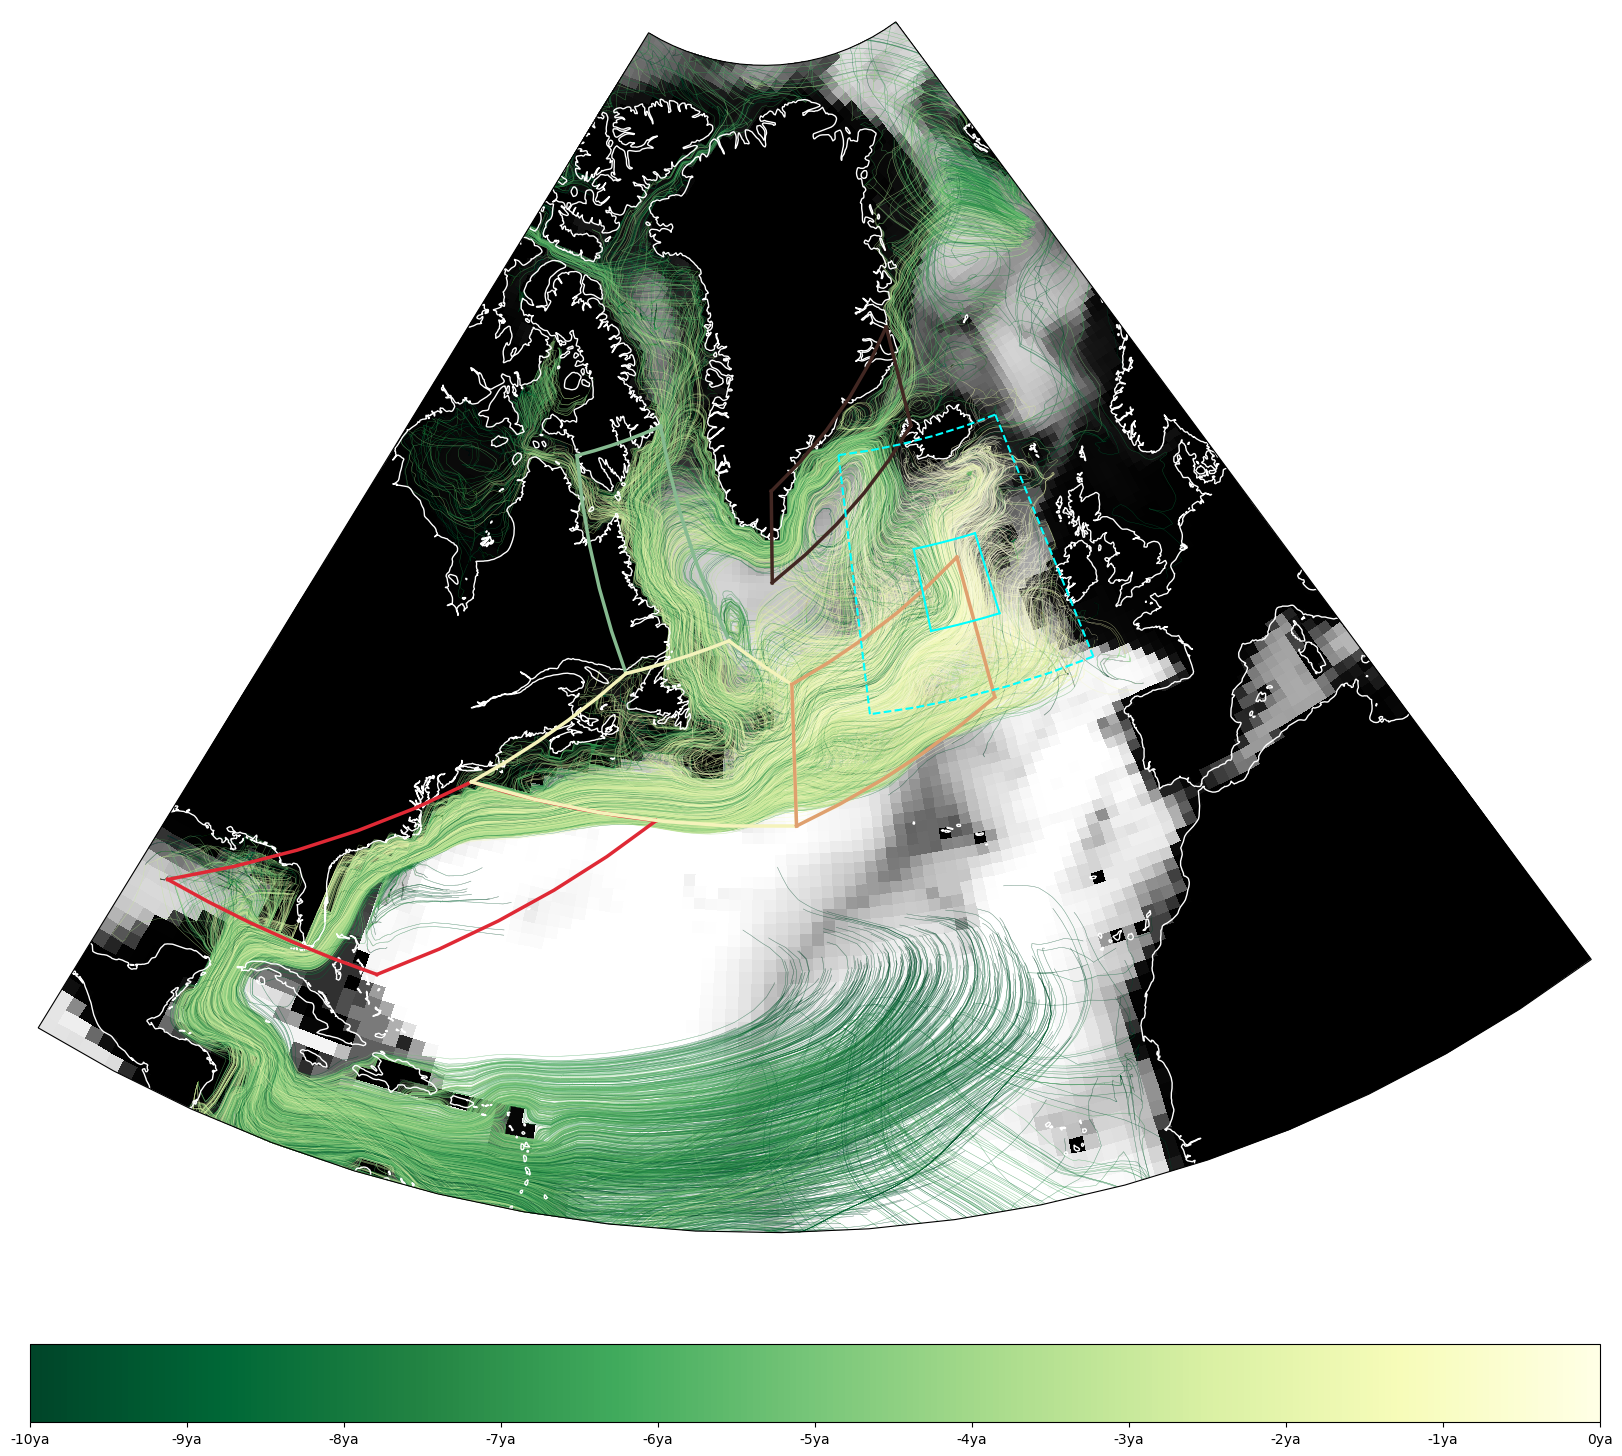

In [45]:
mean_stream_plot(
    lats,
    lons,
    times,
    projection,
    cmap = mean_time_cmap,
    extent = extent,
    alpha = 0.75,
    save_as = 'figure7(a)'
)